# SNe Simulations with NIR data

In [1]:
import os
import glob
import itertools
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import snpy
import scipy
import george
from peakutils import peak

from multiprocessing import Pool

%config InlineBackend.figure_format = 'retina'
print(f'SNooPy version: v{snpy.__version__}')

SNOOPY_MODEL = 'max_model'
OUT_DIR = f'sim_fits_{SNOOPY_MODEL}'
PROCESSES = 8

SNooPy version: v2.6.0


### Auxiliar Functions

In [2]:
def combinations(iterable, r):
    '''Returns all possible combinations without repetition.
    
    **Note:** the output should be inserted in a list
    
    Parameters
    ==========
    iterable: list-like
        List of items from which the combination is computed.
    r: int
        Numbers of items for the combination.
        
    Returns
    =======
    comb_list: list
        List with all combinations.
    '''
    
    comb_list = list(itertools.combinations(iterable, r))
    
    return comb_list            
            
def mag2flux(mag, zp, mag_err=0.0):
    """Converts magnitudes to fluxes, propagating errors if given.
    
    Parameters
    ----------
    mag : array
        Array of magnitudes.
    zp : float or array
        Zero points.
    mag_err : array, default ``0.0``
        Array of magnitude errors.
        
    Returns
    -------
    flux : array
        Magnitudes converted to fluxes.
    flux_err : array
        Magnitude errors converted to errors in fluxes.
    """

    flux = 10**( -0.4*(mag-zp) )
    flux_err =  np.abs( flux*0.4*np.log(10)*mag_err )

    return flux, flux_err

### Simulations functions

In [3]:
def update_sn_mask(sn, mask, bands):
    """Updates the data of a SN (mjd, flux, mag, etc.) with
    the given mask and bands.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    mask: boolean list
        Mask for the SN data.
    bands: str
        Bands to update with the mask.
        
    Returns
    =======
    sn: SNooPy object
        Updated SN.
    """
    
    for band in bands:
        sn.data[band].MJD = sn.data[band].MJD[mask]
        sn.data[band].magnitude = sn.data[band].magnitude[mask]
        sn.data[band].e_mag = sn.data[band].e_mag[mask]
        # I don't know why this is necessary
        if bands=='JH':
            sn.data[band].mag = sn.data[band].mag[mask]
            sn.data[band].flux = sn.data[band].flux[mask]
            sn.data[band].e_flux = sn.data[band].e_flux[mask]

        new_len = len(sn.data[band].MJD)
        sn.data[band].sids = [0]*new_len
        sn.data[band].__dict__['mask'] = [True]*new_len
        
    return sn
                    
def update_sn_dict(sn, update_dict):
    """Updates the data of a SN (mjd, flux, mag, etc.).
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    update_dict: dict
        Dictionary with new SN data with bands as 
        keys and sub-dictionaries as values. Each sub-dictionary 
        must have `mjd`, `mag` and `mag_err` as keys and their 
        respective values.
        
    Returns
    =======
    sn: SNooPy object
        Updated SN.
    """
    
    for band, data_dict in update_dict.items():

        mjd = data_dict['mjd']
        mag, mag_err = data_dict['mag'], data_dict['mag_err']
        
        sn.data[band].MJD = mjd
        sn.data[band].magnitude = mag
        sn.data[band].mag = mag
        sn.data[band].e_mag = mag_err

        zp = sn.data[band].filter.zp
        flux, flux_err = mag2flux(mag, zp, mag_err)

        # there are some hidden parameters like "_flux" and "_eflux"
        # which are used by other internal functions
        sn.data[band].flux = flux
        sn.data[band]._flux = flux
        sn.data[band].e_flux = flux_err
        sn.data[band]._eflux = flux_err

        # not sure if these are completely necessary, but just in case...
        sn.data[band].sids = np.zeros_like(flux)
        sn.data[band].__dict__['mask'] = np.array([True]*len(flux))
        
    return sn

def filter_coeval_NIRdata(sn):
    """Filters out NIR data of a SNooPy object that are not
    coeval in J and H bands.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
        
    Returns
    =======
    The updated sn.
    """
    
    # NIR bands labels
    NIR_bands = [band for band in sn.allbands() if band in ['J', 'H']]
    NIR_ebands = [f'e_{band}' for band in NIR_bands]  # for errors

    # Find epochs with coeval J and H bands
    sn_df = pd.DataFrame(sn.get_mag_table())
    sn_df.replace(99.900000, np.nan, inplace=True)

    sn_df = sn_df[['MJD'] + NIR_bands + NIR_ebands].dropna()

    # update SN J and H bands data
    NIR_dict = {band:None for band in NIR_bands}
    for band, eband in zip(NIR_bands, NIR_ebands):
        indeces = sn_df[band].dropna().index
        mjd = sn_df['MJD'].loc[indeces].values
        mag = sn_df[band].loc[indeces].values
        mag_err = sn_df[eband].loc[indeces].values
        NIR_dict[band] = {'mjd':mjd, 'mag':mag, 'mag_err':mag_err}

    sn = update_sn_dict(sn, NIR_dict)
    
    return sn

def calculate_metrics(sn, n_epochs):
    """Calculates the metrics for the NIR bands of a SN.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    n_epochs: int
        Number of epochs per NIR band.
        
    Returns
    =======
    m1, m2, m3: floats
        Metrics:- m1 is the phase of the closest epoch to T.max.
                - m2 is the mean phase of the phases.
                - m3 is the difference between the first and last epoch.
        **Note:** m2 is only calculated if n_epochs >= 2, and m3 
        if n_epochs == 3. Otherwise, these are NaNs.
    """

    assert n_epochs<=3, 'Metrics are only calculated for `n_epochs` <= 3'
    phases = sn.data['H'].MJD - sn.Tmax

    if n_epochs==1:
        m1 = phases[0]
        m2 = m3 = np.nan

    elif n_epochs==2:
        m1_ind = np.argmin(np.abs(phases))
        m1 = phases[m1_ind]
        m2 = np.mean(phases)
        m3 = np.nan

    elif n_epochs==3:
        m1_ind = np.argmin(np.abs(phases))
        m1 = phases[m1_ind]
        m2 = np.mean(phases)
        m3 = phases[-1] - phases[0]
        
    return m1, m2, m3

def find_peak_mag(sn, band):
    """Extracts the peak magnitude+error of
    a fitted SN. This is used for other SNooPy
    models that are not max_model.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    band: str
        Band to use.
        
    Returns
    =======
    peak_mag: float
        Peak magnitude in the given band.
    peak_mag_err: float
        Peak magnitude error in the given band.
    """
    times = np.arange(sn.Tmax-10, sn.Tmax+20, 0.01)
    mag, mag_err, mask = sn.model(band, times)
    peak_id = peak.indexes(-mag, thres=.3, min_dist=10)[0]
    
    peak_mag, peak_mag_err = mag[peak_id], mag_err[peak_id]
    
    return peak_mag, peak_mag_err

def get_parameter(sn, parameter, include_sys=False):
    """Obtains the value of the given parameter and
    the total (systematics + statistical) uncertainty
    of a fitted SN.
    
    **Note:** NaN is returned if the parameter is not
    found.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    parameter: str
        Parameter to extract.
    include_sys: bool
        If `True`, systematic uncertainties are 
        included.
        
    Returns
    =======
    value: float
        Value of the parameter.
    err: float
        Total uncertainty in the parameter. 
    """
    
    if parameter in sn.parameters.keys():
        value = sn.parameters[parameter]
        stats_err = sn.errors[parameter]
        if include_sys:
            sys_err = sn.systematics()[parameter]
        else:
            sys_err = 0.0
        err = np.sqrt(stats_err**2 + sys_err**2)
    else:
        value = err = np.nan
    
    return value, err

def extract_lc_params(sn):
    """Extracts the estimated light-curve parameters.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
        
    Returns
    =======
    lc_dict: dict
        Dictionary with the light-curve parameter names as keys
        and parameter values as values.
    """

    parameters = ['Tmax', 'st', 'gmax', 'rmax', 'Jmax', 'Hmax']
    lc_dict = {}
    
    for parameter in parameters:
        if parameter not in ['Tmax', 'st'] and 'max_model' not in str(sn.model):
            band = parameter[0]
            value, value_err = find_peak_mag(sn, band)
        else:
            value, value_err = get_parameter(sn, parameter)

        lc_dict[parameter] = value
        lc_dict[parameter+'_err'] = value_err
        
    return lc_dict

In [4]:
def fit_combinatory(sn, n_epochs):
    """Fits a SN multiple times for all the combinatories given by `n_epochs`.
    The fits are performed with grJ, grH and grJH bands.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    n_epochs: int
        Number of items per combinatory.
    """
    assert n_epochs<=3, 'Combinatories are only calculated for `n_epochs` <= 3'
    
    # outputs directories
    if not os.path.isdir(OUT_DIR):
        os.mkdir(OUT_DIR)
        
    sn_dir = os.path.join(OUT_DIR, sn.name)
    if not os.path.isdir(sn_dir):
        os.mkdir(sn_dir)

    # output parameters
    parameters = ['comb', 'm1', 'm2', 'm3', 
                  'Tmax', 'Tmax_err', 'st', 'st_err',
                  'gmax', 'gmax_err', 'rmax', 'rmax_err',
                  'Jmax', 'Jmax_err', 'Hmax', 'Hmax_err']
    NIR_bands = ['J', 'H', 'JH'] 
    
    all_results_dict = {band:{param:[] for param in parameters}
                                                for band in NIR_bands}
    # set of bands to fit
    set_bands2fit = [['g', 'r', 'J'], 
                     ['g', 'r', 'H'],  
                     ['g', 'r', 'J', 'H']] 
    
    # iterate over each combination of bands
    for band, bands2fit in zip(NIR_bands, set_bands2fit):   
        if band in ['J', 'H']:
            length = len(sn.data[band].MJD)
        elif band=='JH':
            # use only common J and H epochs
            sn = filter_coeval_NIRdata(sn)
            length = len(sn.data['J'].MJD)
        combs = combinations(range(length), n_epochs)
        
        # iterate over each combinatory/simulation
        for i, comb in enumerate(combs):
            sn_copy = deepcopy(sn)
            
            # create mask to update SN
            mask = [False]*length
            for ind in comb:
                mask[ind] = True
                
            sn_copy = update_sn_mask(sn_copy, mask, band)
        
            try:
                sn_copy.fit(bands2fit)

                # save plot
                outfile = f'{sn.name}_{n_epochs}epochs_comb{i}_{band}.jpg'
                outfile = os.path.join(sn_dir, outfile)
                sn_copy.plot(outfile=outfile) 

                # time metrics
                m1, m2, m3 = calculate_metrics(sn_copy, n_epochs)
                all_results_dict[band]['comb'].append(i)
                all_results_dict[band]['m1'].append(m1)
                all_results_dict[band]['m2'].append(m2)
                all_results_dict[band]['m3'].append(m3)

                # light-curve parameters
                lc_dict = extract_lc_params(sn_copy)
                for key, value in lc_dict.items():
                    all_results_dict[band][key].append(value)

            except Exception as message:
                print(f'Combinatory number {i} failed for {sn.name}: {message}!')

    # save results for J, H and JH
    for keys, results_dict in all_results_dict.items():
        results_df = pd.DataFrame(results_dict)
        output_file = f'{sn.name}_{n_epochs}epochs_results_{keys}.csv'
        results_file = os.path.join(sn_dir, output_file)
        results_df.to_csv(results_file, index=False)

### Screen

Create a screen with name: `screen -S <name>`.

Detach the screen: `Ctrl-a + d`.

Resume screen session: `screen -r <name>`.

### Parallelisation

In [42]:
def run_fits(input_pair):
    """Function to parallelise `fit_combinatory`.
    
    Parameters
    ==========
    input_pair: list
        List with the first item a SN file (str) 
        and the second item `n_epochs` (int).
        
    Example
    =======
    processes = 8
    Pool(processes).map(run_fits, 
                        ([sn_name, n_epochs] 
                            for sn_file in sn_files))
    """
    
    sn_file, n_epochs = input_pair
    sn = snpy.import_lc(sn_file)
    sn.choose_model(SNOOPY_MODEL)
    try:
        fit_combinatory(sn, n_epochs)
    except Exception as message:
        print(f'{sn.name} failed with n_epochs={n_epochs}: {message}')

In [36]:
# with open('reference_files.txt') as ref_file:
#     sn_files = ref_file.read().splitlines()

# for n_epochs in range(1, 4):
#     print(f'Fitting SNe with n_epochs={n_epochs}')
#     %time Pool(PROCESSES).map(run_fits, ([sn_file, n_epochs] for sn_file in sn_files[:2]))

In [39]:
with open('reference_files.txt') as ref_file:
    sn_files = ref_file.read().splitlines()

%time Pool(PROCESSES).map(run_fits, ([sn_file, 1] for sn_file in sn_files[:2]))

SNhunt281 failed with n_epochs=1: All weights for filter J are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
CPU times: user 58.3 ms, sys: 147 ms, total: 205 ms
Wall time: 59 s


[None, None]

Combinatory number 10 failed for SNhunt281: All weights for filter J are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.!
Combinatory number 11 failed for SNhunt281: All weights for filter J are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.!
Combinatory number 7 failed for SNhunt281: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Combinatory number 8 failed for SNhunt281: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Combinatory number 10 failed for SNhunt281: All weights for filter H are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.!
Combinatory number 11 failed for SNhunt281: All weights for filter H are zer

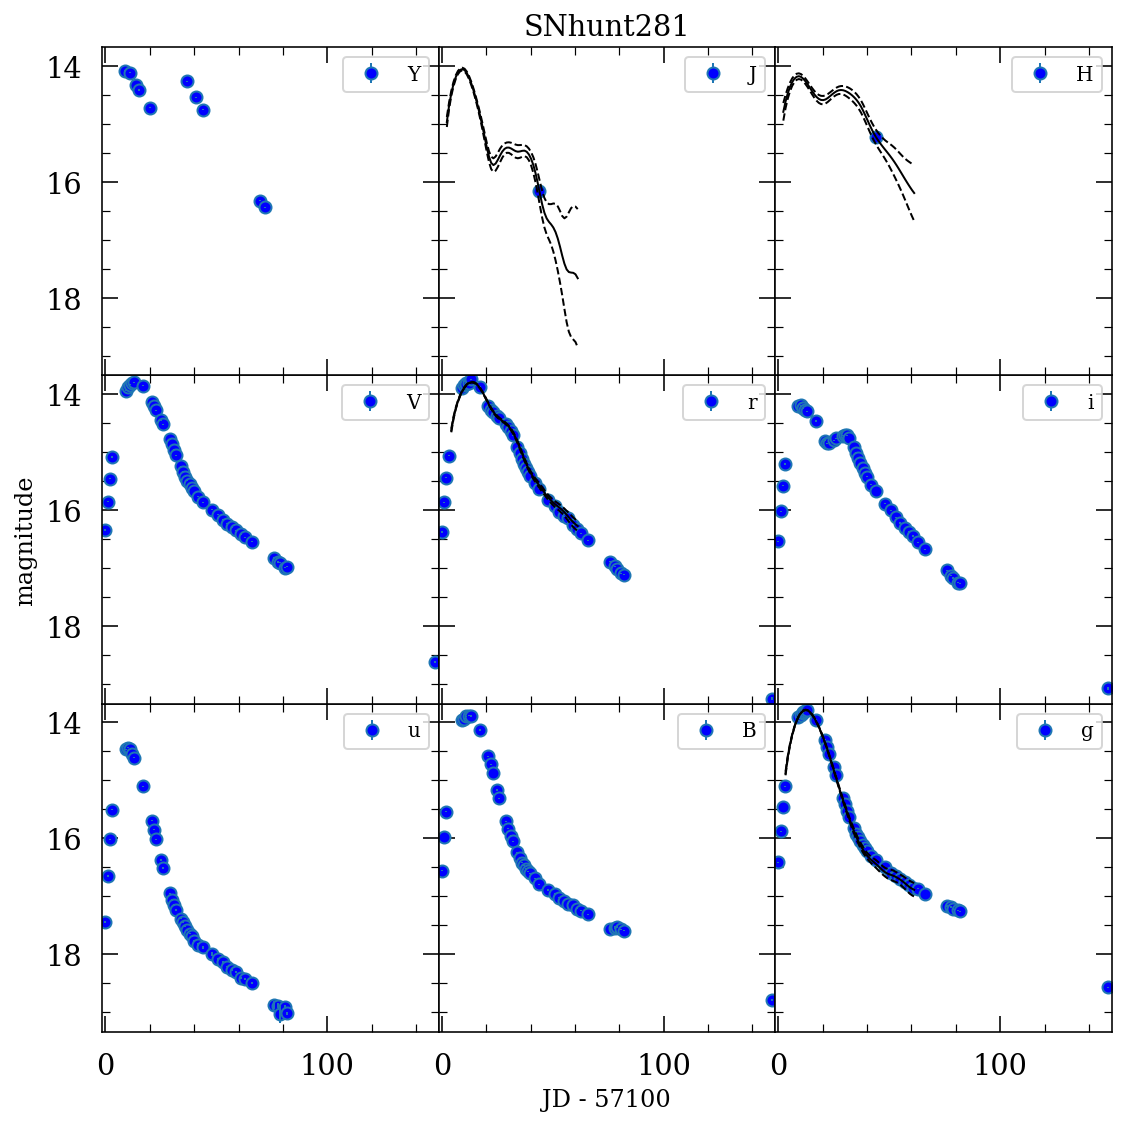

In [43]:
with open('reference_files.txt') as ref_file:
    sn_files = ref_file.read().splitlines()
    
sn = snpy.import_lc(sn_files[1])
sn.choose_model(SNOOPY_MODEL)
fit_combinatory(sn, 1)